In [1]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
from pickle import dump
import lmfit
import numpy as np
import scipy.stats as ss
plt.style.use('neuron')
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols, rlm
import sys
sys.path.append('../')
from Linearity import Neuron

In [2]:
def simpleaxis(axes, every=False):
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

In [3]:
def getNumBins(X, rule="S"):

    if rule == "FD":
        # Freedman‐Diaconis Rule!
        minMax = max(X) - min(X)
        Qx = sp.stats.iqr(X)
        N_cubrt = np.cbrt(len(X))
        print (minMax, Qx, N_cubrt, minMax/(2.* Qx * N_cubrt))
        return int(np.ceil(minMax/(2.* Qx * N_cubrt)))
    elif rule == "S":
        # Sturges’ Rule!
        return int(np.ceil(1. + np.log2(len(X))))

def calc_MI(X,Y,bins):

    c_X = np.histogram(X, bins=bins)[0]
    c_Y = np.histogram(Y, bins=bins)[0]
    c_XY = np.histogram2d(X,Y, bins=bins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_XY = shan_entropy(c_XY)

    MI = H_X + H_Y - H_XY
    normalized_MI = MI    # In bits, or normalize: /(np.sqrt(H_X*H_Y))
    return normalized_MI

def calc_TI(X,Y,Z,bins):

    c_X = np.histogram(X, bins=bins)[0]
    c_Y = np.histogram(Y, bins=bins)[0]
    c_Z = np.histogram(Z, bins=bins)[0]

    c_XY = np.histogram2d(X,Y, bins=bins)[0]
    c_XYZ = np.histogramdd((X,Y,Z), bins=bins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_Z = shan_entropy(c_Z)

    H_XY = shan_entropy(c_XY)
    H_XYZ = shan_entropy(c_XYZ)

    TI = H_Z + H_XY - H_XYZ
    normalized_TI = TI  # In bits, or normalize: /(np.sqrt(H_X*H_Y))
    return normalized_TI


def shan_entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized* np.log2(c_normalized))
    return H

In [4]:
currentClampFiles = '/media/sahil/NCBS_Shares_BGStim/patch_data/current_clamp_files.txt'
with open (currentClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [5]:
feature = 0
scalingFactor = 1e9
neurons = {}
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = dirname + 'plots/' + cellIndex + '.pkl'
    n = Neuron.load(filename)
    neurons[str(n.date) + '_' + str(n.index)] = n

In [6]:
feature = 0 # Area under the curve
neuron = neurons['170303_c1']
expected, observed, g_expected, g_observed, time = {}, {}, {}, {}, {}
for expType, exp in neuron:
    ## Control case
    if(expType == "Control"):
        expected = []
        observed = []
        time = []
        sqrArr = []
        for sqr in exp:
            if sqr > 1:
                for coord in exp[sqr].coordwise:
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            expected.append(exp[sqr].coordwise[coord].expected_feature[feature])
                            observed.append(trial.feature[feature])
                            time.append(np.argmax(trial.interestWindow)/20.)
                            sqrArr.append(sqr)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  


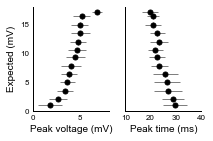

In [26]:
expected, observed, time = np.array(expected), np.array(observed), np.array(time)
bins = np.linspace(0, 20, 15)
digitized = np.digitize(expected, bins)
ex_means = [expected[digitized == i].mean() for i in range(1, len(bins))]
ob_means = [observed[digitized == i].mean() for i in range(1, len(bins))]
t_means = [time[digitized == i].mean() for i in range(1, len(bins))]

ex_std = [expected[digitized == i].std() for i in range(1, len(bins))]
ob_std = [observed[digitized == i].std() for i in range(1, len(bins))]
t_std = [time[digitized == i].std() for i in range(1, len(bins))]

fig, ax = plt.subplots(1,2, sharey=True)
ax[0].errorbar(ob_means, ex_means, xerr=ob_std, yerr=ex_std, c='k', fmt='.')
ax[1].errorbar(t_means, ex_means, xerr=t_std, yerr=ex_std, c='k', fmt='.')

ax[0].set_xlim(0,8)
ax[1].set_xlim(10,40)
ax[0].set_xlabel('Peak voltage (mV)')
ax[1].set_xlabel('Peak time (ms)')
ax[0].set_ylabel('Expected (mV)')
simpleaxis(ax)
fig.set_figheight(2)
fig.set_figwidth(3)
fig.tight_layout()
dump(fig,file('figures/fig7/7a.pkl','wb'))
plt.show()

# ax[0].scatter(observed, expected, s= 10)
# ax[1].scatter(time, expected, s= 10)
# ax[0].set_xlim(0,10)
# ax[1].set_xlim(0,50)
# ax[0].set_xlabel('Observed peak voltage (mV)')
# ax[1].set_xlabel('Peak time (ms)')
# ax[0].set_ylabel('Expected peak voltage (mV)')
# simpleaxis(ax)
# dump(fig,file('figures/fig7/7a.pkl','wb'))
# plt.show()

In [27]:
bins = int(min([getNumBins(expected) , getNumBins(observed) , getNumBins(time)])/1.5)

In [10]:
I_te = calc_MI(time, expected,bins)
I_oe = calc_MI(observed, expected,bins)
I_ote = calc_TI(time, observed, expected ,bins)

In [11]:
I_te, I_oe, I_ote

(0.25954713341413704, 0.395451093272988, 0.67928525514478189)

## Calculating MI for all cells

In [12]:
I_te, I_oe, I_ote = [], [], []
feature = 0 # Area under the curve
for index in neurons:
    neuron = neurons[index]
    for expType, exp in neuron:
        ## Control case
        if(expType == "Control"):
            expected = []
            observed = []
            time = []
            sqrArr = []
            for sqr in exp:
                if sqr > 1:
                    for coord in exp[sqr].coordwise:
                        for trial in exp[sqr].coordwise[coord].trials:
                            if all([value == 0 for value in trial.flags.values()]):
                                expected.append(exp[sqr].coordwise[coord].expected_feature[feature])
                                observed.append(trial.feature[feature])
                                time.append(np.argmax(trial.interestWindow)/20.)
                                sqrArr.append(sqr)
            if len(expected):
                bins = int(min([getNumBins(expected) , getNumBins(observed) , getNumBins(time)])/1.5)
                I_te.append(calc_MI(time, expected,bins))
                I_oe.append(calc_MI(observed, expected,bins))
                I_ote.append(calc_TI(time, observed, expected ,bins))

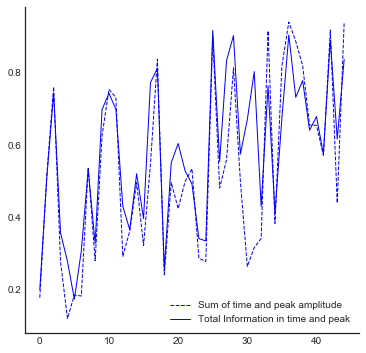

In [21]:
I_te, I_oe, I_ote = np.array(I_te), np.array(I_oe), np.array(I_ote)
fig, ax = plt.subplots()
indices = np.argsort(I_te)
# ax.plot(I_te[indices], c='r', label="Time")
# ax.plot(I_oe[indices], c='g', label="Peak amplitude")
ax.plot(I_te[indices] + I_oe[indices], 'b--', label="Sum of time and peak amplitude")
ax.plot(I_ote[indices], c='b', label="Total Information in time and peak")
simpleaxis(ax)
plt.legend()
fig.set_figheight(6)
fig.set_figwidth(6)
plt.savefig('figures/Fig_7_b.png')
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
plt.show()

In [25]:
observed = np.array(observed)
time = np.array(time)
expected = np.array(expected)

print(shan_entropy(time) + shan_entropy(observed))

17.010449338


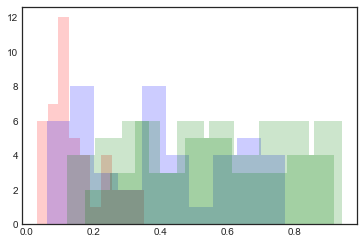

In [18]:
fig, ax = plt.subplots()
ax.hist(I_te, color='r', alpha=0.2)
ax.hist(I_oe, color='b', alpha=0.2)
ax.hist(I_te + I_oe, color='g', alpha=0.2)
ax.hist(I_ote, color='g', alpha=0.2)
plt.show()